In [2]:
import pandas as pd
import numpy as np
import folium
import matplotlib as plt
import sys
from pandas import DataFrame
from pandas import read_csv, read_excel
import seaborn as sns

In [3]:
train = pd.read_excel('안전비상벨위치정보.xlsx')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# 그래프 한글 설정
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

In [5]:
train.columns

Index(['번호', '안전비상벨관리번호', '설치목적', '설치장소유형', '설치위치', '소재지도로명주소', '소재지지번주소',
       'WGS84위도', 'WGS84경도', '연계방식', '경찰연계유무', '경비업체연계유무', '관리사무소연계유무', '부가기능',
       '안전비상벨설치연도', '최종점검일자', '최종점검결과구분', '관리기관명', '관리기관전화번호', '데이터기준일자'],
      dtype='object')

In [6]:
df = train[['WGS84위도', 'WGS84경도']]
df = df.iloc[0:1500, :]
df = df.to_numpy()
df

array([[ 37.48472219, 126.9448623 ],
       [ 37.49274898, 126.9350922 ],
       [ 37.47331235, 126.9236363 ],
       ...,
       [ 37.60638162, 127.0091733 ],
       [ 37.60749279, 127.0076468 ],
       [ 37.60857871, 127.007949  ]])

In [7]:
print(df[0][0], df[0][1])
print(df[1][0], df[1][1])

37.48472219 126.9448623
37.49274898 126.9350922


In [8]:
# m = folium.Map(location=[37.53897093698831, 127.05461953077439], 
#                zoom_start=14, 
#                )
# for i in range(0, 1500):
#         folium.Marker([df[i][0], df[i][1]]).add_to(m)
# m

In [9]:
from haversine import haversine

In [10]:
# 위경도 입력
one = (df[0][0], df[0][1])  #Latitude, Longitude
two = (df[1][0], df[1][1])
three = (df[2][0], df[3][1])
four = (df[3][0], df[3][1])
# 거리 계산
haversine(four, three, unit = 'km')

0.7316469486750149

In [11]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [12]:
generate_candidate_sites(df)

array([[ 37.48212681, 126.94192341],
       [ 37.63622517, 127.03469896],
       [ 37.61013211, 127.00463855],
       [ 37.54005969, 127.03072691],
       [ 37.60153314, 127.05608801],
       [ 37.49370338, 126.96314028],
       [ 37.49611794, 127.0042468 ],
       [ 37.56926328, 126.98852423],
       [ 37.49959821, 126.98939575],
       [ 37.58927517, 126.95996198],
       [ 37.56162223, 126.98770582],
       [ 37.53693065, 127.00885666],
       [ 37.45639793, 126.93420692],
       [ 37.49680411, 127.01189069],
       [ 37.56545442, 127.04083425],
       [ 37.49017392, 126.96488461],
       [ 37.48361253, 126.93715828],
       [ 37.47724795, 126.97627562],
       [ 37.61168117, 127.06553012],
       [ 37.60541961, 126.96184634],
       [ 37.63866884, 127.01912076],
       [ 37.58125329, 127.00344788],
       [ 37.51713851, 127.04076768],
       [ 37.53197099, 127.03729924],
       [ 37.65308951, 127.00441491],
       [ 37.4643874 , 126.96756843],
       [ 37.47780073, 126.99414805],
 

----- Configurations -----
  Number of points 1500
  K 5
  Radius 10
  M 100
----- Output -----
  Running time : 0.1260232925415039 seconds
  Optimal coverage points: 1500


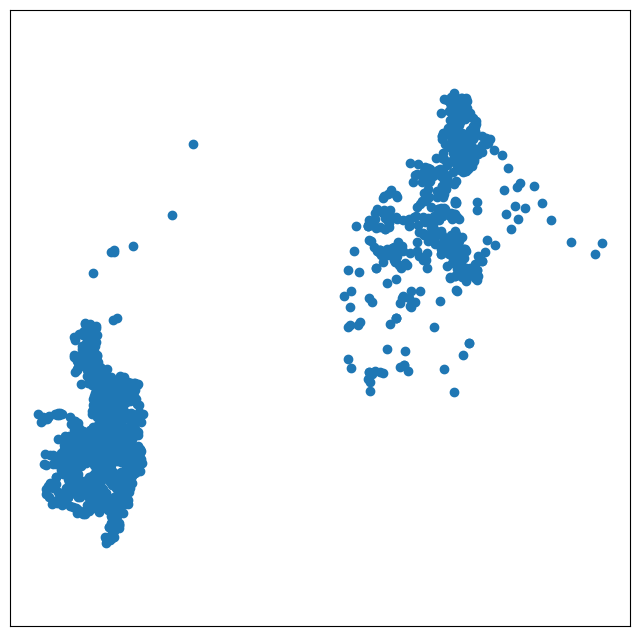

In [14]:
mclp(df, 5, 10, 100)
plot_input(df)

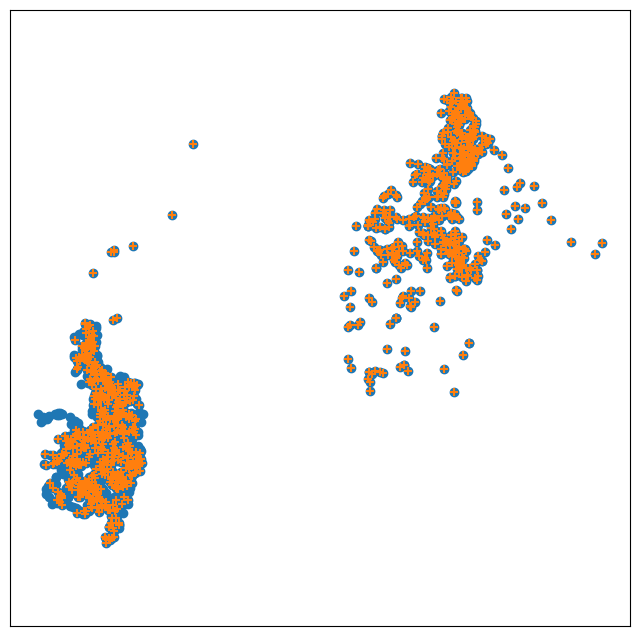

In [20]:
plot_result(df, df[500:], 10)